### Importing data

In [2]:
import pandas as pd

df_raw = pd.read_csv("../data/raw_data.csv")
#because the index will give some error when doing OneHot, I remove the index for now
df_raw.to_csv("../data/raw_data.csv", index = False)

### Preprocessing

In [3]:
#selecting only the data for houses
df = df_raw[df_raw['PropertySubType'] == 'HOUSE']
#For the model I only want to work with the variable with the best correlation (Price-LivingArea-BedroomCount):
df = df[['Price', 'LivingArea','Province','BedroomCount','PropertySubType']]
#removing the rows with empty Prices and LivingArea
df.dropna(subset=['Price', 'LivingArea'], inplace=True)
#removing index from df because otherwise it gives NaN-values becaus after cleaning, indexes are non exsistent
df.reset_index(drop=True, inplace=True) 

#saving the new dataFrame:
#path for the CSV file
output_file_path = "../data/preprocessed_data.csv"
# Save df to CSV file
df.to_csv(output_file_path, index=False)

#returns: df


### Split data

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#split the data
#1. defining X (without the target-variable) and y (=target-value):
X = df.drop(columns=['Price','PropertySubType'], axis=1)
y = df['Price']
#2. create the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)  #training with 20% of the dataset

#dealing with categorical data for'Province': turn categories into numbers:
one_hot = OneHotEncoder(handle_unknown = "ignore", sparse_output=False)
transformed_X_train = one_hot.fit_transform(X_train[['Province']])
#converting output into a DataFrame
transformed_X_df_train = pd.DataFrame(transformed_X_train, columns=one_hot.get_feature_names_out(['Province']))
#add transfromed_X_df to the original df
df_conc_train = pd.concat([X_train.reset_index(), transformed_X_df_train], axis=1).drop("Province", axis=1)

transformed_X_test = one_hot.transform(X_test[['Province']])
#converting output into a DataFrame
transformed_X_df_test = pd.DataFrame(transformed_X_test, columns=one_hot.get_feature_names_out(['Province']))
#add transfromed_X_df to the original df
df_conc_test = pd.concat([X_test.reset_index(), transformed_X_df_test], axis=1).drop("Province", axis=1)

#returns: df_conc_test, df_conc_train,y_train, y_test


### Choosing Model

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib

#choosing model:
model = LinearRegression()
model.fit(df_conc_train, y_train)

# File path to save the model
model_file_path = "../models/lin_regres_houses.pkl"
# Save the model to disk
joblib.dump(model, model_file_path)
model = joblib.load('../models/lin_regres_houses.pkl')

y_pred= model.predict(df_conc_test)
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Sqaured Error for this model is: ", mse)
print("Score from train-set = ", model.score(df_conc_train, y_train))
print("Score from test-set = ", model.score(df_conc_test, y_test))

Score from train-set =  0.3558271467919799
Score from test-set =  0.2895837633829954


### Crossvalidation

In [6]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
# Define the number of folds for cross-validation
num_folds = 5

#cross-validation strategy
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)  # Set random_state if you want reproducible results

# Perform
scores = cross_val_score(model, df_conc_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Convert scores to positive values
mse_scores = -scores

# Calculate mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

# Print the mean and standard deviation of MSE scores
print("Mean MSE:", mean_mse)
print("Standard Deviation of MSE:", std_mse)

Mean MSE: 82669964242.73036
Standard Deviation of MSE: 27820757887.777004


### Visualization prediction vs actual data

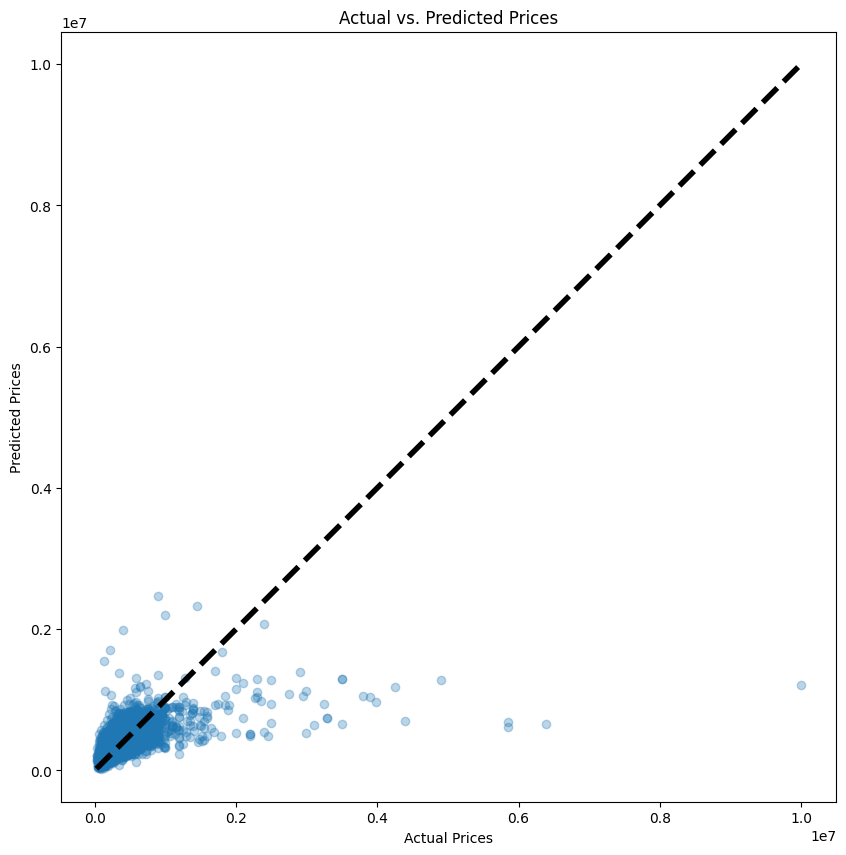

In [7]:
import matplotlib.pyplot as plt

# Assuming `y_test` contains the actual prices and `y_pred` contains the model's predictions
actual = y_test
predicted = y_pred

plt.figure(figsize=(10, 10))
plt.scatter(actual, predicted, alpha=0.3)
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Plotting the perfect prediction line
plt.plot([actual.min(), actual.max()], [
         actual.min(), actual.max()], 'k--', lw=4)
plt.axis('equal')

plt.show()